# File loading and imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


weo_subject_code_col = 'WEO Subject Code'
estimates_after_col = 'Estimates Start After'
iso_col = 'ISO'
country_name_col = 'Country'
selected_cols = [iso_col, weo_subject_code_col, country_name_col]
for i in range(1980, 2020):
    selected_cols.append(str(i))
selected_cols.append(estimates_after_col)

# file is manually downloaded, and must be placed in root path
# https://www.imf.org/~/media/Files/Publications/WEO/WEO-Database/2020/02/WEOOct2020all.ashx
# in order to to auto download requires checksum for file to ensure 
# integrity of file
df = pd.read_table(
    'WEOOct2020all.xls',
    encoding='UTF-16-LE',
    usecols=selected_cols,
)

# 1. Select top 10 countries which increased GDP the most

* selection is done based on delta from 2019 to 2018 GDP in common dollars
* WEO code NGDPRPPPPC - Gross domestic product per capita, constant prices

In [2]:
''' select top 10 GDP per capita countries '''

# filtering gdp per capita
ngdprppppc_key = 'NGDPRPPPPC'
def gdp_per_capita_common_dollar(col):
    return col[weo_subject_code_col] == ngdprppppc_key

# select relevant rows from loaded doc
gdp_per_capita_df = df.loc[gdp_per_capita_common_dollar]

# creating dataframe for sorting
# https://stackoverflow.com/a/57064872
year_col = '2019'
previous_year_col = str(int(year_col)-1)
gdp_increase_col = f'GDP Increase from {previous_year_col} to {year_col}'

def col_to_float(input_df, column_name):
    return input_df[column_name].replace(regex=',', value='').astype(float)

gdp_per_capita_df[year_col] = col_to_float(gdp_per_capita_df, year_col)

gdp_per_capita_df[previous_year_col] = col_to_float(
    gdp_per_capita_df, 
    previous_year_col)

gdp_per_capita_df = gdp_per_capita_df[
    [country_name_col, year_col, previous_year_col]]

gdp_per_capita_df = gdp_per_capita_df.set_index(country_name_col)

# calculate difference between two columns row by row
# example wasnt much help :)
# https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

# calculate difference between two columns row by row
# ran into issues that calculation showed zeros every 
# lost datatype :/
# calculate difference between two columns row by row
data = []
for row in gdp_per_capita_df.itertuples():
    # data appended to new data source
    # Country name
    # year 
    # previous year
    # delta 
    data.append([row[0], row[1], row[2], row[1] - row[2]])

gdp_per_capita_df = pd.DataFrame(
    data,
    columns=[country_name_col, year_col, previous_year_col, gdp_increase_col])
gdp_per_capita_df = gdp_per_capita_df.set_index(country_name_col).astype(float)
gdp_per_capita_df = gdp_per_capita_df.dropna()

# sorting on gdp increase col
gdp_per_capita_df = gdp_per_capita_df.sort_values(
    gdp_increase_col, ascending=False, na_position='last')

# select top 10
gdp_per_capita_df[:10]


,2019,2018,GDP Increase from 2018 to 2019
Country,,,
Ireland,88227.656,84417.518,3810.138
Estonia,36976.362,35292.537,1683.825
Lithuania,37021.250,35389.685,1631.565
Hungary,32612.668,31065.165,1547.503
Romania,29951.356,28592.603,1358.753
Poland,33084.702,31764.070,1320.632
Taiwan Province of China,51112.948,49794.907,1318.041
Libya,13598.932,12498.714,1100.218
Denmark,57295.941,56222.510,1073.431


In [3]:
def prepare_oecd_countries():
    oecd_countries_all_caps = {
        'AUSTRIA': '',
        'AUSTRALIA': '',
        'BELGIUM': '',
        'CANADA': '',
        'CHILE': '',
        'COLOMBIA': '',
        'CZECH REPUBLIC': '',
        'DENMARK': '',
        'ESTONIA': '',
        'FINLAND': '',
        'FRANCE': '',
        'GERMANY': '',
        'GREECE': '',
        'HUNGARY': '',
        'ICELAND': '',
        'IRELAND': '',
        'ISRAEL': '',
        'ITALY': '',
        'JAPAN': '',
        'KOREA': '',
        'LATVIA': '',
        'LITHUANIA': '',
        'LUXEMBOURG': '',
        'MEXICO': '',
        'NETHERLANDS': '',
        'NEW ZEALAND': '',
        'NORWAY': '',
        'POLAND': '',
        'PORTUGAL': '',
        'SLOVAK REPUBLIC': '',
        'SLOVENIA': '',
        'SPAIN': '',
        'SWEDEN': '',
        'SWITZERLAND': '',
        'TURKEY': '',
        'UNITED KINGDOM': '',
        'UNITED STATES': ''}
    # properly formatting OECD country names
    oecd_countries = {}
    for key in oecd_countries_all_caps:
        oecd_countries[key.title()] = ''
    
    return oecd_countries
    
oecd_countries = prepare_oecd_countries()

# 2. Draw OECD countries population change in last decade

* selection is done based delta from 2019 to 2018 GDP in common dollars
* WEO code LP - Population

<Figure size 432x288 with 0 Axes>

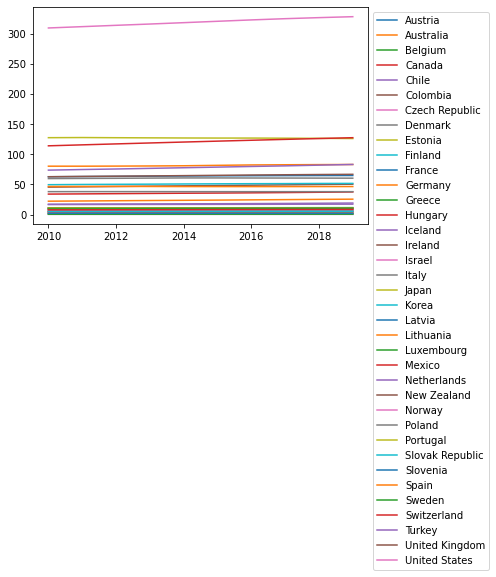

In [4]:
'''
plot of OECD countries population
'''

population_key = 'LP'

# creating dataframe on population
population_df = df.loc[(df[weo_subject_code_col] == population_key)]

# sets index and index is stored for future
population_df = population_df.set_index(country_name_col)

# filtering oecd contries
population_df = population_df.loc[oecd_countries]

# building decade column array
decade = []
for i in range(2010, 2020):
    decade.append(str(i))

# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
# selecting decade colums
population_df = population_df[decade]
# converting to plotable time series, transpose
population_df = population_df.T

# wrong data type is set needs to cast to numeris type
population_df = population_df.astype(float)

# select only limited subset of countries instead of all as it population
# change is better visible if passed ['Lithuania', 'Latvia', 'Iceland']
population_df = population_df[oecd_countries]


plt.figure()
population_df.plot()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# 3. Draw all countries GDP and save to disk as png

* WEO code NGDPD - Gross domestic product, current prices

In [5]:
'''save all countries GDP in different PNG files'''

# Gross domestic product, current prices
# Values are based upon GDP in national currency converted to U.S. dollars
gdp_key = 'NGDPD'

gdp_df = df.loc[lambda df: df[weo_subject_code_col] == gdp_key]

# setting index country name
gdp_df = gdp_df.set_index(country_name_col)

# filtering non required columns
selected_cols = []

for col in gdp_df.columns:
    if col == iso_col or col == weo_subject_code_col or col == estimates_after_col:
        continue

    selected_cols.append(col)

# select country name column and period columns
gdp_df = gdp_df[selected_cols]

# https://stackoverflow.com/a/49896522
# applies lambda to rows, cleans numeric values of thousands separator
gdp_df = gdp_df.apply(lambda df: df.str.replace(',', '').astype(float), axis=0)

# prepare folder for pics
figure_folder_name = 'figures'
if not os.path.exists(figure_folder_name):
    os.makedirs(figure_folder_name)

# add [0:1] to save limited subset
for country in gdp_df.index:
    # print(country)
    # https://stackoverflow.com/a/45379210
    fig = gdp_df.loc[country].plot().get_figure()
    # https://stackoverflow.com/a/4805178
    # if face color is not set explicitly its trasnparet, wtf
    fig.savefig(f'{os.path.join(figure_folder_name, country)}.png',
                format='png', transparent=False, facecolor='white')
    # closes the plot, as no need to display, while saving
    # https://stackoverflow.com/a/15713545
    plt.close(fig)


# 4. Find lowest common denominator for year 2015

In [6]:
''' find lowest common denominator for year 2015 '''
# create dataframe of WEO codes and 2015 year
common_denominator_df = df[[weo_subject_code_col, '2015']]

# removes all na values
common_denominator_df = common_denominator_df.dropna()

# selecting only WEO code and grouping to display
common_denominator_df = common_denominator_df[[weo_subject_code_col]]
common_denominator_df = common_denominator_df.groupby([weo_subject_code_col])

# common_denominator_df.apply(print)
# https://stackoverflow.com/a/36951842
# simple print
lowest_common_denom = []
for key in common_denominator_df.groups.keys():
    lowest_common_denom.append(key)

# uncoment for display
lowest_common_denom


['BCA',
 'BCA_NGDPD',
 'FLIBOR6',
 'GGR',
 'GGR_NGDP',
 'GGSB',
 'GGSB_NPGDP',
 'GGX',
 'GGXCNL',
 'GGXCNL_NGDP',
 'GGXONLB',
 'GGXONLB_NGDP',
 'GGXWDG',
 'GGXWDG_NGDP',
 'GGXWDN',
 'GGXWDN_NGDP',
 'GGX_NGDP',
 'LE',
 'LP',
 'LUR',
 'NGAP_NPGDP',
 'NGDP',
 'NGDPD',
 'NGDPDPC',
 'NGDPPC',
 'NGDPRPC',
 'NGDPRPPPPC',
 'NGDP_D',
 'NGDP_FY',
 'NGDP_R',
 'NGDP_RPCH',
 'NGSD_NGDP',
 'NID_NGDP',
 'PCPI',
 'PCPIE',
 'PCPIEPCH',
 'PCPIPCH',
 'PPPEX',
 'PPPGDP',
 'PPPPC',
 'PPPSH',
 'TMG_RPCH',
 'TM_RPCH',
 'TXG_RPCH',
 'TX_RPCH']

# 5. Group countries by GDP and Value of exported goods using clustering algorithm
 
* a. draw graph where x - GDP, y - volume of exported goods
* b. label top 5 countries of each cluster

params used:
 
* WEO code NGDPD - Gross domestic product, current prices
* WEO code TXG_RPCH  - Volume of exports of goods

In [7]:
''' K-Means clustering '''


# still requires GDP_key
volume_of_exported_goods_key = 'TXG_RPCH'

# TODO: move to function as this code is duplicated
# Gross domestic product, current prices
# Values are based upon GDP in national currency converted to U.S. dollars
gdp_key = 'NGDPD'
year_col = '2019'


gdp_x_exported_goods_df = df
gdp_x_exported_goods_df = gdp_x_exported_goods_df.set_index(weo_subject_code_col)


# select gdp rows
gdp_key_df = gdp_x_exported_goods_df.loc[[gdp_key]]
gdp_key_df = gdp_key_df[[year_col]]


# select exported goods
exported_goods_df = gdp_x_exported_goods_df.loc[[volume_of_exported_goods_key]]
exported_goods_df = exported_goods_df[[country_name_col, year_col]]

gdp_x_exported_goods_df = gdp_x_exported_goods_df.reset_index()

input_list = []
for i in range(len(exported_goods_df)):
    row = exported_goods_df.iloc[i]
    input_list.append([
        row[country_name_col],
        gdp_key_df.iloc[i][year_col],
        row[year_col]
    ])

kmeans_input = pd.DataFrame(
    data=input_list,
    columns=[country_name_col, gdp_key, volume_of_exported_goods_key])
kmeans_input = kmeans_input.apply(lambda df: df.str.replace(',', ''), axis=1)
kmeans_input[gdp_key] = kmeans_input[gdp_key].astype(float).fillna(0.0)


# https://numpy.org/doc/stable/reference/generated/numpy.nan_to_num.html
X = np.array(kmeans_input[[gdp_key, volume_of_exported_goods_key]])
X = X.astype(np.float)
X = np.nan_to_num(X)


# had to normalize data, didnt help :D
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

cluster_count = 5

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=cluster_count).fit(X)
## prints debug data
# print(kmeans.labels_, len(kmeans.labels_))
# print(kmeans.cluster_centers_)

cluster_col = 'cluster' 
kmeans_input[cluster_col] = kmeans.labels_

## finds closest to centroids, as this is not very relevant to task :)
## https://stackoverflow.com/a/62234949
# from scipy.cluster.vq import vq
# closest, distances = vq(kmeans.cluster_centers_, X)
# print('closest to centroids: ', closest, distances)


### plot the data
* 5a. plot clustered data
* 5b. label top 5 countries in cluster

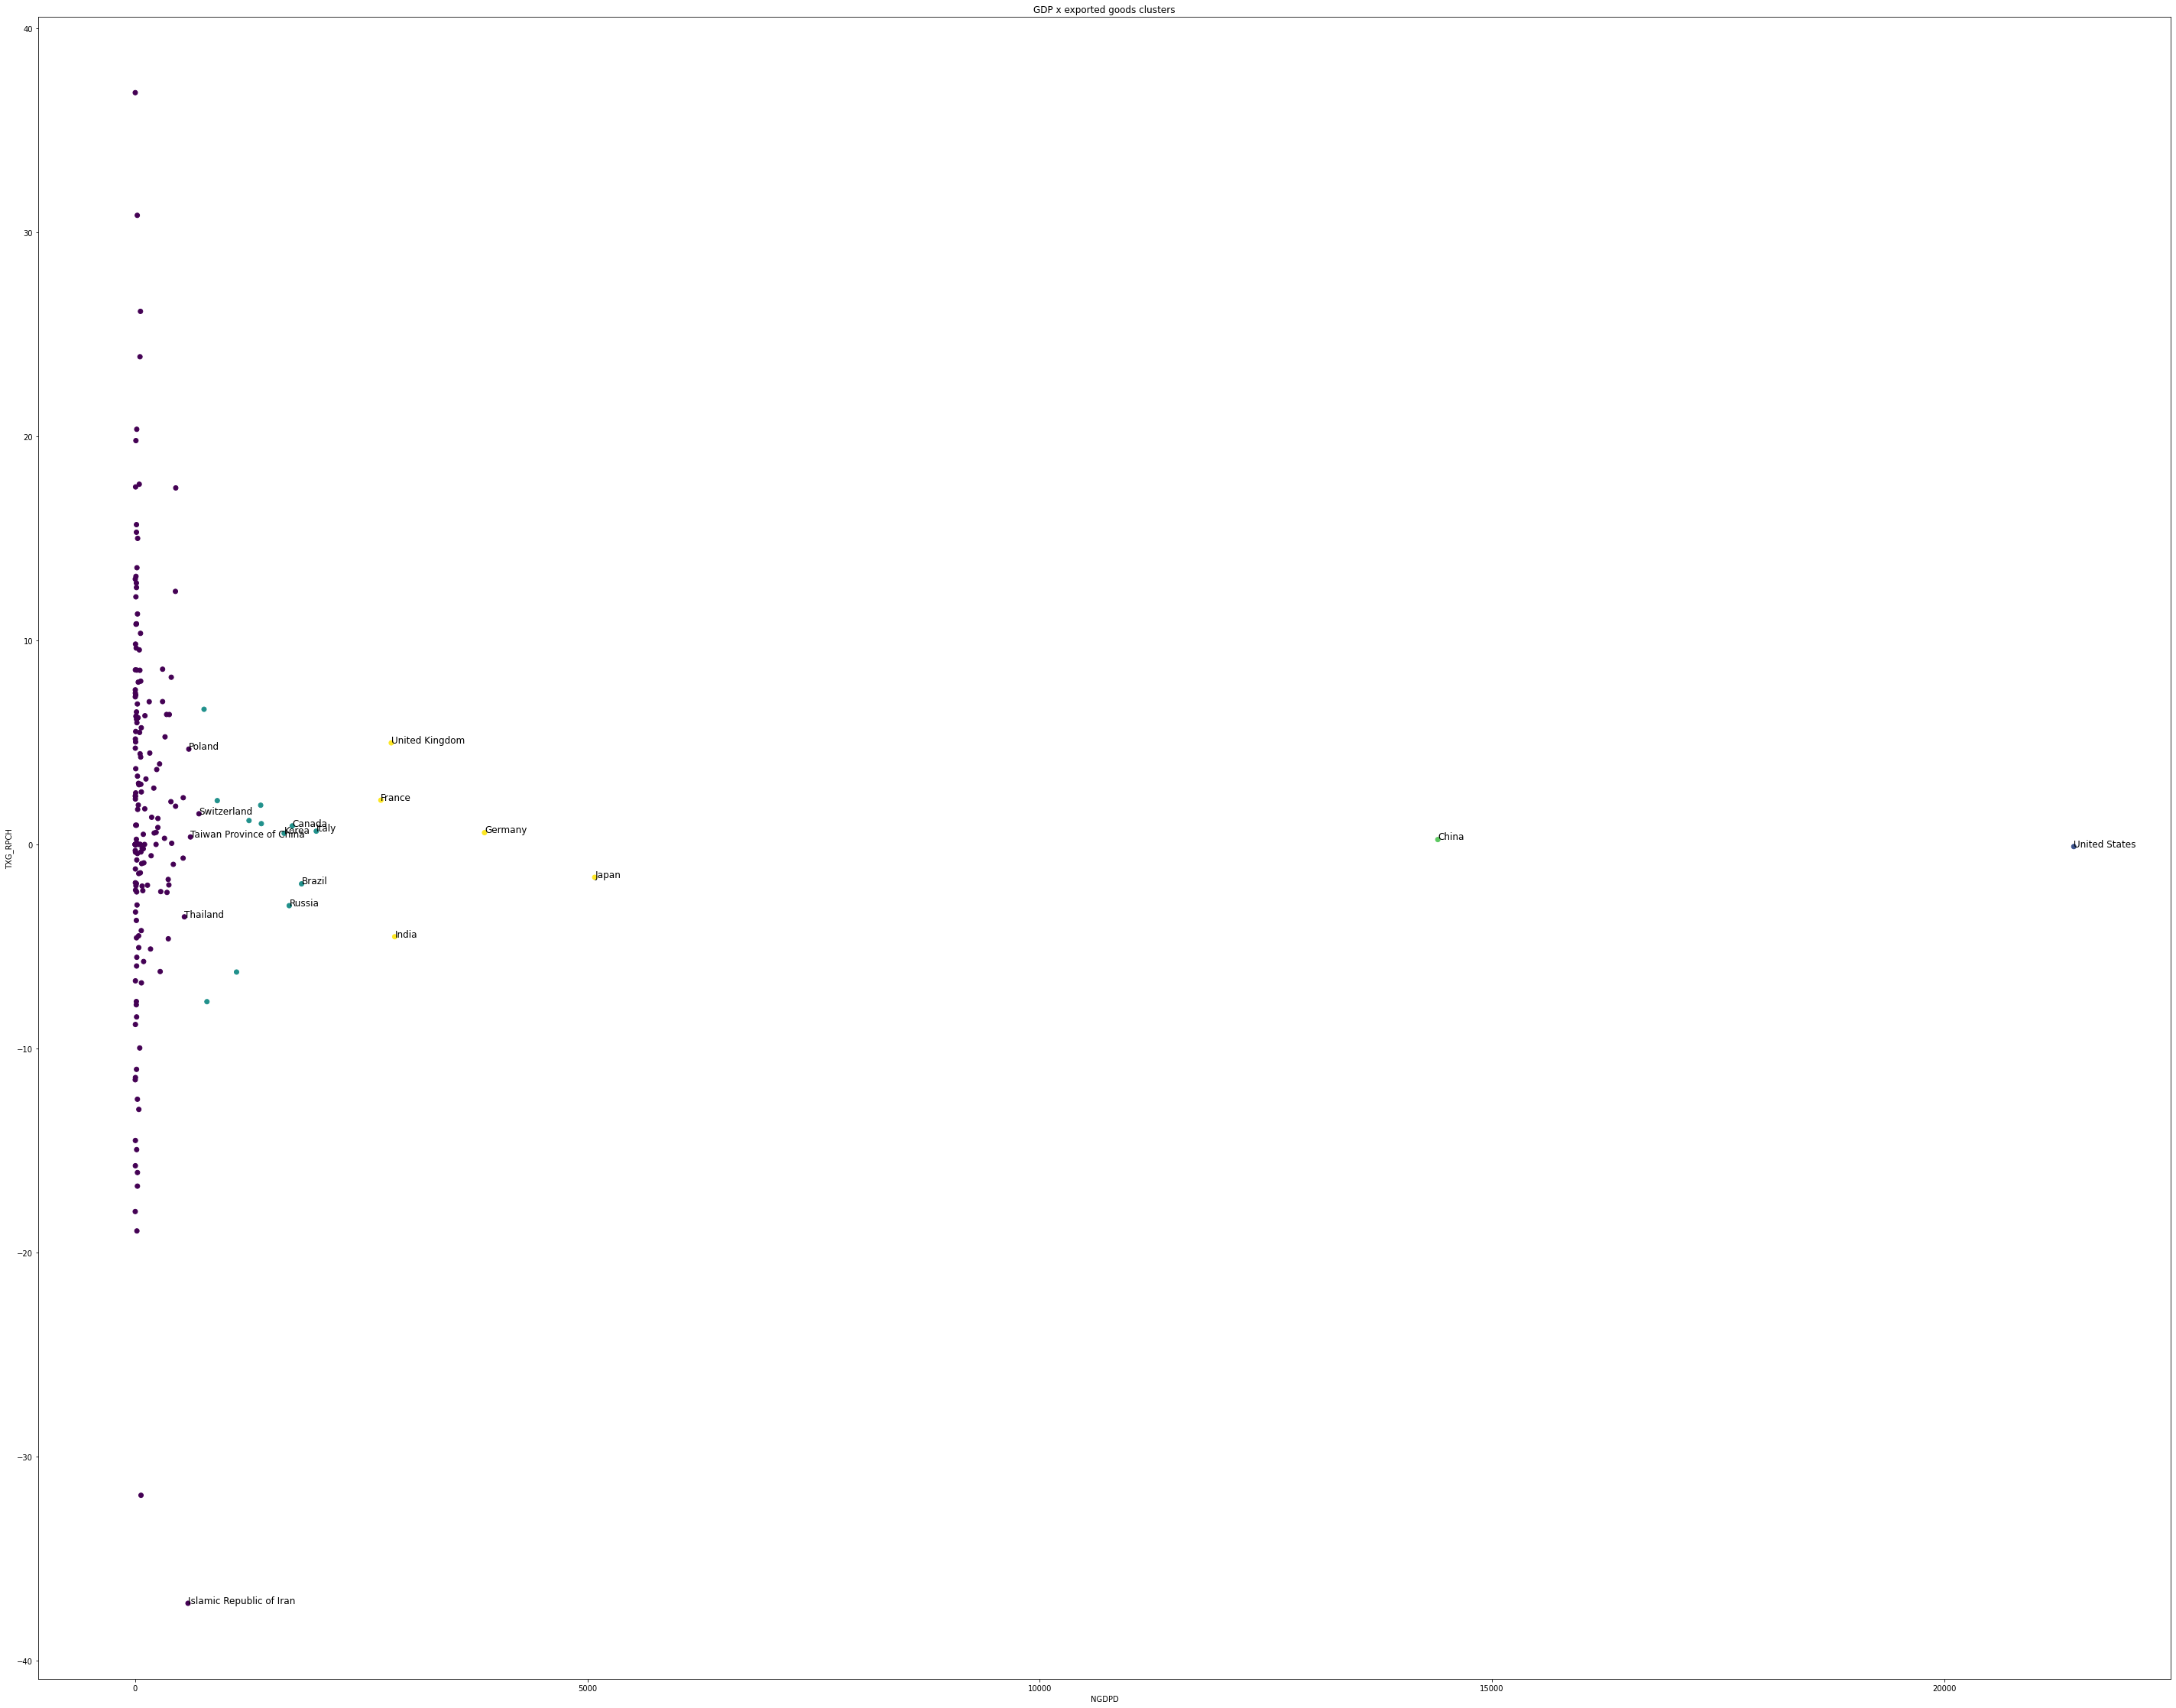

In [8]:
''' plot cluster data '''
# https://stackoverflow.com/a/47474302
plt.figure(figsize=(50, 40))
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_.astype(float))
plt.title("GDP x exported goods clusters")
plt.xlabel(gdp_key)
plt.ylabel(volume_of_exported_goods_key)
plt.plot()


# this will annotate top five from selected amount of clusters
for i in range(0, cluster_count):
    cluster = kmeans_input.loc[kmeans_input[cluster_col] == i]
    # need top 5 so if less than cluster size annotate all
    if len(cluster) >= cluster_count:
        cluster = cluster.sort_values(
            gdp_key, ascending=False, na_position='last')
        # select top 5
        cluster = cluster[:5]

    for row in cluster.itertuples():
        plt.annotate(
            row[1], # country name
            (X[row[0]][0],X[row[0]][1]), # gdp / exported goods
            fontsize=12
        )

# 6. Predicts GDP per capita using scikit library without using other GDP related fields
* a. Prints predictor MSE on training set
* b. Prints initial training params
* c. selects 5 most impactful and retrains predictor
* d. saves predictor to file

Feature: 0, Score: -42.30369, weo_key: PCPI
Feature: 1, Score: -152.09578, weo_key: PCPIPCH
Feature: 2, Score: 72.66102, weo_key: PCPIE
Feature: 3, Score: 82.55836, weo_key: PCPIEPCH
Feature: 4, Score: 0.00000, weo_key: FLIBOR6
Feature: 5, Score: 7.05798, weo_key: TM_RPCH
Feature: 6, Score: -18.69654, weo_key: TMG_RPCH
Feature: 7, Score: 0.16123, weo_key: TX_RPCH
Feature: 8, Score: -53.97299, weo_key: TXG_RPCH
Feature: 9, Score: 337.83090, weo_key: LUR
Feature: 10, Score: 1126.81148, weo_key: LE
Feature: 11, Score: -149.22338, weo_key: LP
Feature: 12, Score: 0.50719, weo_key: GGR
Feature: 13, Score: -0.50380, weo_key: GGX
Feature: 14, Score: -0.68407, weo_key: GGXCNL
Feature: 15, Score: -0.01379, weo_key: GGSB
Feature: 16, Score: 0.17584, weo_key: GGXONLB
Feature: 17, Score: -0.00623, weo_key: GGXWDN
Feature: 18, Score: 0.00178, weo_key: GGXWDG
Feature: 19, Score: 14.38776, weo_key: BCA


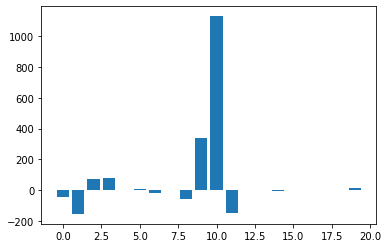

[(0, -42.30369052280492, 'PCPI'), (1, -152.09578078346755, 'PCPIPCH'), (2, 72.66101643444136, 'PCPIE'), (3, 82.55836041520762, 'PCPIEPCH'), (4, 1.4660805902622087e-10, 'FLIBOR6'), (5, 7.057975092915104, 'TM_RPCH'), (6, -18.69653966033177, 'TMG_RPCH'), (7, 0.1612275845768551, 'TX_RPCH'), (8, -53.97299218152866, 'TXG_RPCH'), (9, 337.83089540446895, 'LUR'), (10, 1126.8114820381275, 'LE'), (11, -149.22337958088272, 'LP'), (12, 0.5071879146011469, 'GGR'), (13, -0.5038006974930056, 'GGX'), (14, -0.6840714278173206, 'GGXCNL'), (15, -0.013790839479810302, 'GGSB'), (16, 0.17584302666328178, 'GGXONLB'), (17, -0.006226023648764567, 'GGXWDN'), (18, 0.001776850425756038, 'GGXWDG'), (19, 14.387762009667652, 'BCA')]




Mean squared error: 1214773346.21
Coefficient of determination: -0.58


In [9]:
''' GDP per capita prediction '''

# select non GDP related weo keys
gdp_weo_key = 'GDP'


def country_select(df): return df[country_name_col] == 'Germany'


# use regular expr with bitmask to filter out all GDP related fields
# https://stackoverflow.com/a/17097777
input_features = df[
    ~df[weo_subject_code_col].str.contains(gdp_weo_key, na=False)
    & ~df[weo_subject_code_col].str.contains('PPP', na=False)].fillna(0.0)


def gdp_per_capita_common_dollar(col): return col[weo_subject_code_col] == ngdprppppc_key


ngdprppppc_key = 'NGDPRPPPPC'


def prepare_country_data(input_features, country_select):
    drop_clumns = [country_name_col, iso_col, estimates_after_col]

    input_features = input_features.loc[country_select]
    input_features = input_features.drop(columns=drop_clumns)
    input_features = input_features.T

    # save feature column codes
    feature_weo_codes = []

    # building feature data frame
    cleand_features = []
    i = 0
    for row in input_features.itertuples():
        # filtered out data set return 20 features
        if len(row) < 21:
            continue
        # index, dont care about this in transposed dataframe
        if row[0] == weo_subject_code_col:
            feature_weo_codes = row[1:]
            continue

        float_fts = []
        # manually filtering out wrong values
        # as somewhere lost types :/
        for x in row[1:]:

            if type(x) == str:
                # some columns contains -- instead of n/a
                if x == '--':
                    float_fts.append(0.0)
                else:
                    float_fts.append(float(x.replace(',', '')))
            else:
                float_fts.append(float(x))
        cleand_features.append(float_fts)


    drop_columns_inlcuding_weo = [country_name_col,
                                  iso_col, estimates_after_col, weo_subject_code_col]

    gdp_data = df.loc[gdp_per_capita_common_dollar].dropna()
    gdp_data = gdp_data.loc[country_select].drop(
        columns=drop_columns_inlcuding_weo)

    # preparing result set
    cleand_result = []
    for row in gdp_data.T.itertuples():
        if len(row) < 2:
            continue

        cleand_result.append(float(row[1].replace(',', '')))

    return (cleand_features, cleand_result, feature_weo_codes)


def select_training_countries():
    countries_list = input_features[[country_name_col]]
    countries_list = countries_list.set_index(country_name_col)
    countries_list = countries_list.groupby(country_name_col)
    filtered_countries = []
    for i, key in enumerate(countries_list.groups.keys()):
        if type(key) != str:
            continue

        if i % 3 == 0 or key == 'Germany' or key == 'Italy':
            filtered_countries.append(key)

    return filtered_countries

# debug info: stores info on failed input/output params generation
failed_result_gen = []
cleand_features = []
cleand_result = []
feature_weo_codes = []
for c_name in select_training_countries():
    gdp_features, gdp_result, weo_codes = prepare_country_data(
        input_features=input_features,
        country_select=lambda df: df[country_name_col] == c_name)
    # if for some reason no result data log it
    if len(gdp_result) < 1:
        failed_result_gen.append(c_name)
        continue

    feature_weo_codes = weo_codes
    # append features and results
    for row in gdp_features:
        cleand_features.append(row)

    for x in gdp_result:
        cleand_result.append(x)

# cleand_result
# a bit hardcoded stuff, as there are 1800 rows or stmh,
# so its aroud 30% left for testing data set
slice_length = -600
training_features = cleand_features[:slice_length]
training_gdp = cleand_result[:slice_length]

# selected test data set
training_features_test = cleand_features[slice_length:]
training_gdp_test = cleand_result[slice_length:]

# training
# https://machinelearningmastery.com/make-predictions-scikit-learn/
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

model = LinearRegression()
model.fit(training_features, training_gdp)

def get_filter_coeficients_for_manual_selection():
    filter_coefs = []
    # # get importance
    importance = model.coef_
    # summarize feature importance
    for i, v in enumerate(importance):
        print_t = (i, v, feature_weo_codes[i])
        print('Feature: %0d, Score: %.5f, weo_key: %s' % print_t)
        filter_coefs.append(print_t)
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    return filter_coefs

## prints and plots initial features
print(get_filter_coeficients_for_manual_selection())

# prediction
predict = training_features_test
result = training_gdp_test

result_predicted = model.predict(predict)

def print_MSE(result_set, predicted_set):
    # https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
    # The mean squared error
    print('\n')
    print('\n')
    print('Mean squared error: %.2f'
        % mean_squared_error(result_set, predicted_set))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
        % r2_score(result_set, predicted_set))

print_MSE(result, result_predicted)


### auto selecting top 5 features and saving to file

In [10]:
''' auto feature selection '''
# https://machinelearningmastery.com/feature-selection-for-regression-data/
# feature selection


def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k=5)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs


# feature selection
X_train_fs, X_test_fs, fs = select_features(
    training_features, training_gdp, training_features_test)

# get selected features
# https://stackoverflow.com/a/43765224

auto_selected_features = fs.get_support(indices=True)

best_features = []
for i in auto_selected_features:
    best_features.append(feature_weo_codes[i])

print(f'GDP not related features:\n {feature_weo_codes}')
print('')
print(f'Auto selected top 5:\n {best_features}')

# fit the model
model5 = LinearRegression()
model5.fit(X_train_fs, training_gdp)
# evaluate the model
yhat = model5.predict(X_test_fs)
# evaluate predictions
mse = mean_squared_error(training_gdp_test, yhat)
print_MSE(training_gdp_test, yhat)

# save to file
file_name = 'filename5.joblib'
dump(model5, file_name)


GDP not related features:
 ('PCPI', 'PCPIPCH', 'PCPIE', 'PCPIEPCH', 'FLIBOR6', 'TM_RPCH', 'TMG_RPCH', 'TX_RPCH', 'TXG_RPCH', 'LUR', 'LE', 'LP', 'GGR', 'GGX', 'GGXCNL', 'GGSB', 'GGXONLB', 'GGXWDN', 'GGXWDG', 'BCA')

Auto selected top 5:
 ['PCPI', 'PCPIE', 'LUR', 'LE', 'LP']




Mean squared error: 1366932961.71
Coefficient of determination: -0.78


['filename5.joblib']